In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [10]:
df = pd.read_csv('/home/andyliu/s25-coopai/data/0501_rts_oai.csv', sep='|')
df.head()

,timestamp,round_index,p1_choice,p1_move,p2_choice,p1_payoff,p2_payoff,p1_gain_from_simulating,p1_simulation_error,p2_simulation_prompt,...,arg_p1_model,arg_p2_model,arg_temperature,arg_payoff_matrix_path,arg_rounds,arg_simulation_cost,arg_simulation_type,arg_matrix_number,arg_csv_output,arg_verbose
0,2025-05-01 21:56:39,0,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,gpt-4.1,gpt-4.1,1.0,test.json,20,0.0,simulate_and_best_response,0,/home/andyliu/s25-coopai/data/0501_rts_oai.csv,False
1,2025-05-01 21:56:39,1,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,gpt-4.1,gpt-4.1,1.0,test.json,20,0.0,simulate_and_best_response,0,/home/andyliu/s25-coopai/data/0501_rts_oai.csv,False
2,2025-05-01 21:56:39,2,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,gpt-4.1,gpt-4.1,1.0,test.json,20,0.0,simulate_and_best_response,0,/home/andyliu/s25-coopai/data/0501_rts_oai.csv,False
3,2025-05-01 21:56:39,3,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,gpt-4.1,gpt-4.1,1.0,test.json,20,0.0,simulate_and_best_response,0,/home/andyliu/s25-coopai/data/0501_rts_oai.csv,False
4,2025-05-01 21:56:39,4,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,gpt-4.1,gpt-4.1,1.0,test.json,20,0.0,simulate_and_best_response,0,/home/andyliu/s25-coopai/data/0501_rts_oai.csv,False


In [11]:
df.columns

Index(['timestamp', 'round_index', 'p1_choice', 'p1_move', 'p2_choice',
       'p1_payoff', 'p2_payoff', 'p1_gain_from_simulating',
       'p1_simulation_error', 'p2_simulation_prompt', 'p1_rationale',
       'p2_rationale', 'p1_prob_trust', 'p1_prob_partial_trust',
       'p1_prob_walk_out', 'p1_prob_simulate', 'p2_prob_cooperate',
       'p2_prob_defect', 'p2_simulated_prob_cooperate',
       'p2_simulated_prob_defect', 'stackelberg_p1_prob_trust',
       'stackelberg_p1_prob_partial_trust', 'stackelberg_p1_prob_walk_out',
       'stackelberg_p2_prob_cooperate', 'stackelberg_p2_prob_defect',
       'stackelberg_p1_payoff', 'stackelberg_p2_payoff', 'arg_p1_model',
       'arg_p2_model', 'arg_temperature', 'arg_payoff_matrix_path',
       'arg_rounds', 'arg_simulation_cost', 'arg_simulation_type',
       'arg_matrix_number', 'arg_csv_output', 'arg_verbose'],
      dtype='object')

In [12]:
df['p1_simulate'] = df['p1_choice'].apply(lambda x: 1 if x == 'simulate' else 0)

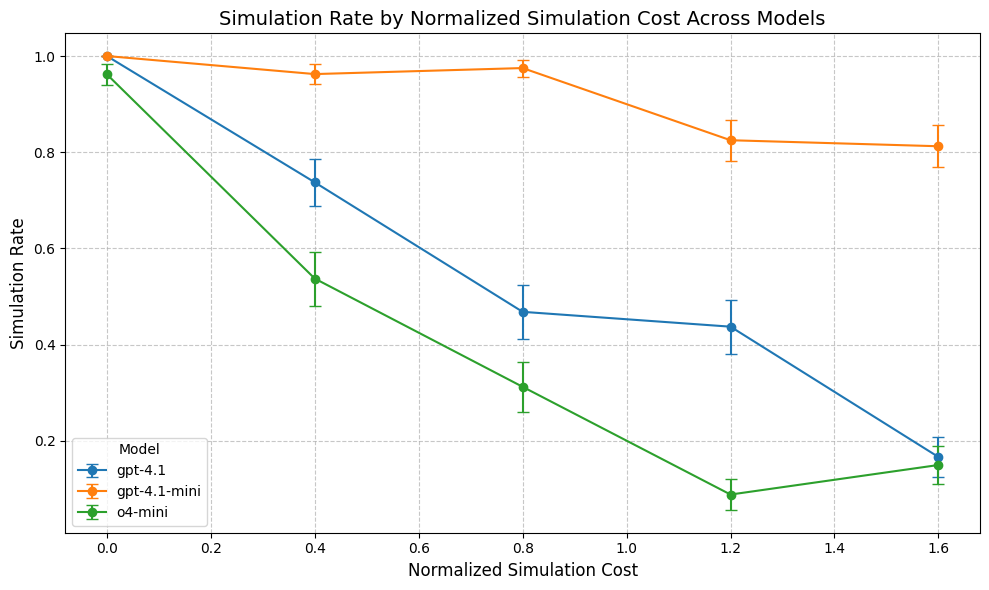

In [23]:
plt.figure(figsize=(10, 6))

# Get unique models
models = df['arg_p1_model'].unique()

# Create a line for each model
for model in models:
    # Filter data for this model
    model_data = df[df['arg_p1_model'] == model]
    
    # Group by simulation_cost and calculate mean and standard error of p1_simulate
    grouped_stats = model_data.groupby('arg_simulation_cost')['p1_simulate'].agg(['mean', 'std', 'count']).reset_index()
    
    # Calculate standard error
    grouped_stats['se'] = grouped_stats['std'] / np.sqrt(grouped_stats['count'])
    
    # Sort by simulation_cost to ensure line is drawn correctly
    grouped_stats = grouped_stats.sort_values('arg_simulation_cost')
    
    # Plot this model's line with error bars
    plt.errorbar(
        grouped_stats['arg_simulation_cost'], 
        grouped_stats['mean'], 
        yerr=grouped_stats['se'],  # Using standard error for error bars
        marker='o', 
        linestyle='-', 
        label=model,
        capsize=4  # Adds caps to the error bars
    )

# Add labels and legend
plt.xlabel('Normalized Simulation Cost', fontsize=12)
plt.ylabel('Simulation Rate', fontsize=12)
plt.title('Simulation Rate by Normalized Simulation Cost Across Models', fontsize=14)
plt.legend(title='Model', loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Improve appearance
plt.tight_layout()
plt.savefig('figures/simulation_rate_by_normalized_simulation_cost_across_models.png')

In [24]:
# get average simulation error by model and simulation type
df.groupby(['arg_p1_model', 'arg_simulation_type'])['p1_simulation_error'].mean()

arg_p1_model  arg_simulation_type       
gpt-4.1       simulate_and_best_response    0.000000
              simulate_externally           0.290179
              simulate_internally           0.726786
              simulate_via_prompting        0.518617
gpt-4.1-mini  simulate_and_best_response    0.000000
              simulate_externally           0.214674
              simulate_internally           0.201099
              simulate_via_prompting        0.258427
o4-mini       simulate_and_best_response    0.000000
              simulate_externally           0.371463
              simulate_internally           0.326608
              simulate_via_prompting        0.293158
Name: p1_simulation_error, dtype: float64

In [29]:
# count nan in f['p1_simulation_error']
df_dropna = df.dropna(subset=['p1_simulation_error'])

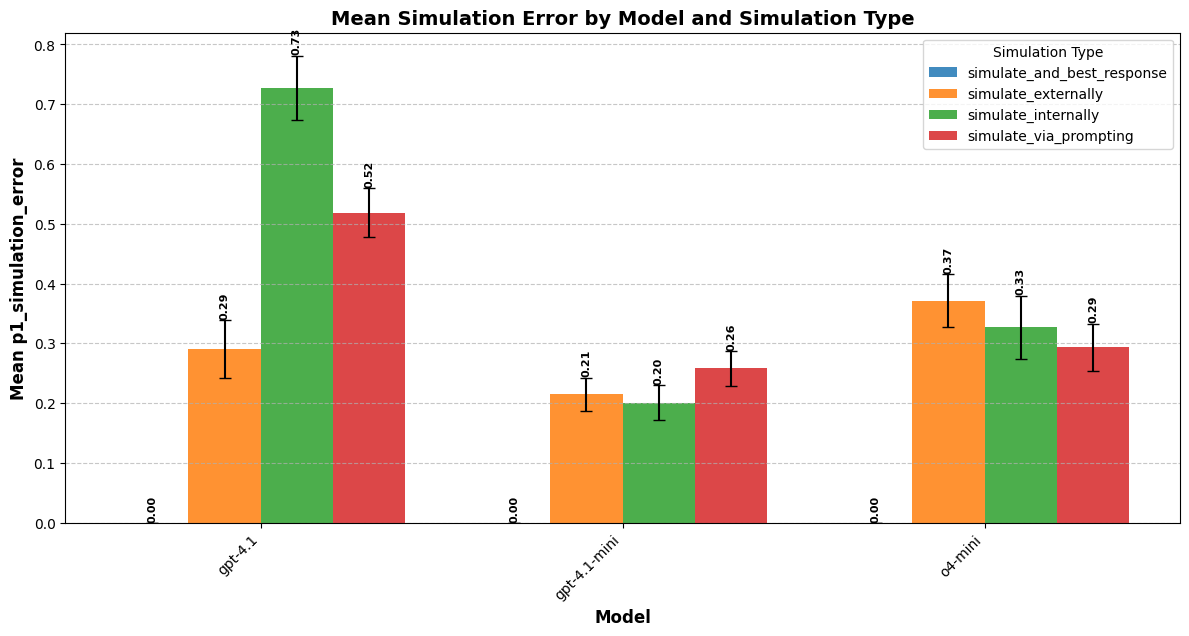

In [ ]:
grouped = df_dropna.groupby(['arg_p1_model', 'arg_simulation_type'])['p1_simulation_error']
means = grouped.mean().unstack()
# Calculate standard error (std/sqrt(n))
errors = grouped.apply(lambda x: stats.sem(x)).unstack()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Set the width of the bars
bar_width = 0.8 / len(means.columns)
positions = np.arange(len(means.index))

# Plot each simulation type as a group of bars
for i, sim_type in enumerate(means.columns):
    # Calculate position for this group
    pos = positions + i * bar_width - (len(means.columns) - 1) * bar_width / 2
    
    # Plot bars with error bars
    bars = ax.bar(
        pos, 
        means[sim_type], 
        width=bar_width, 
        label=sim_type, 
        yerr=errors[sim_type], 
        capsize=4,  # Add caps to error bars
        alpha=0.85  # Slight transparency for better visibility
    )
    
    # Annotate each bar with its value
    for j, bar in enumerate(bars):
        height = bar.get_height()
        value = means[sim_type].iloc[j]
        # Format the value to 2 decimal places
        formatted_value = f'{value:.2f}'
        
        # Position the text above the bar
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + errors[sim_type].iloc[j] * 1.05,  # Position text slightly above error bar
            formatted_value,
            ha='center',            # Horizontal alignment
            va='bottom',            # Vertical alignment
            fontsize=8,             # Smaller font to avoid overlap
            rotation=90,            # Rotate text to avoid overlap
        )

# Customize the plot
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Mean p1_simulation_error', fontsize=12)
ax.set_title('Mean Simulation Error by Model and Simulation Type', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(means.index, rotation=45, ha='right')
ax.legend(title='Simulation Type')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add some space at bottom for rotated labels and at top for the annotations
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, top=0.9)

# Show the plot
plt.savefig('figures/simulation_error_by_model_and_simulation_type.png')

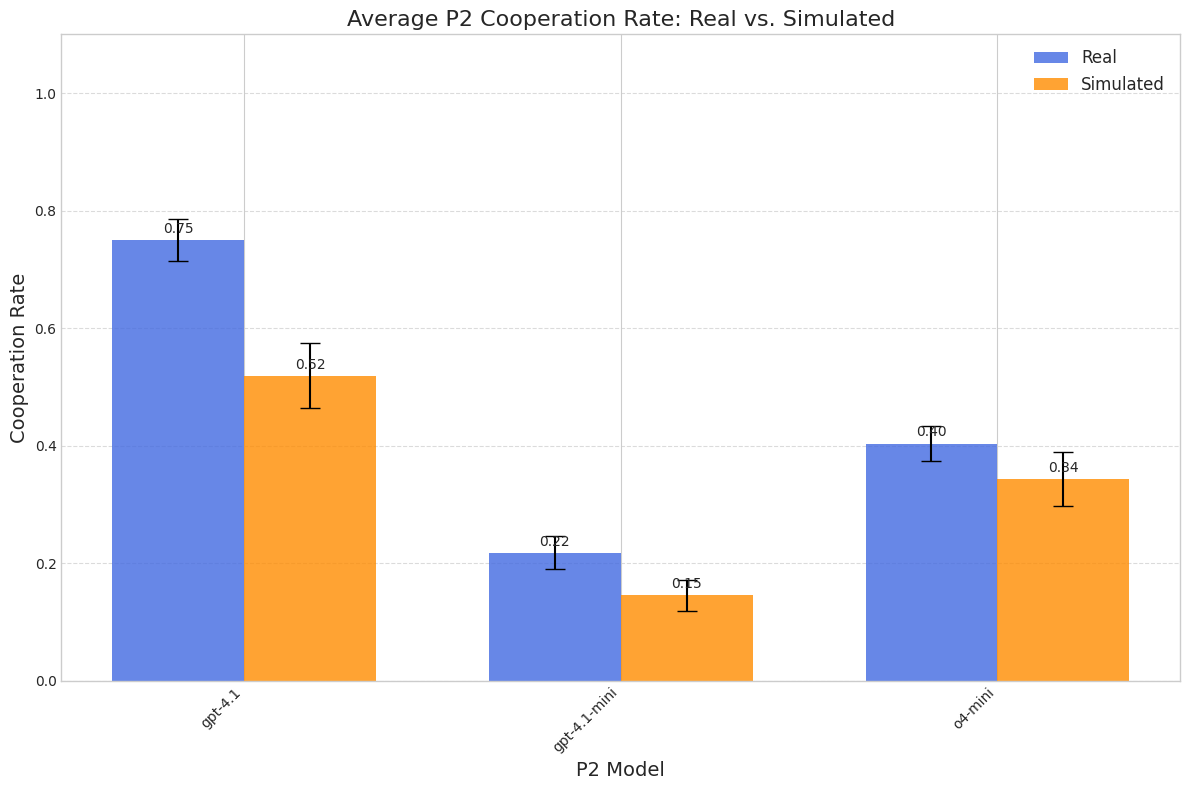

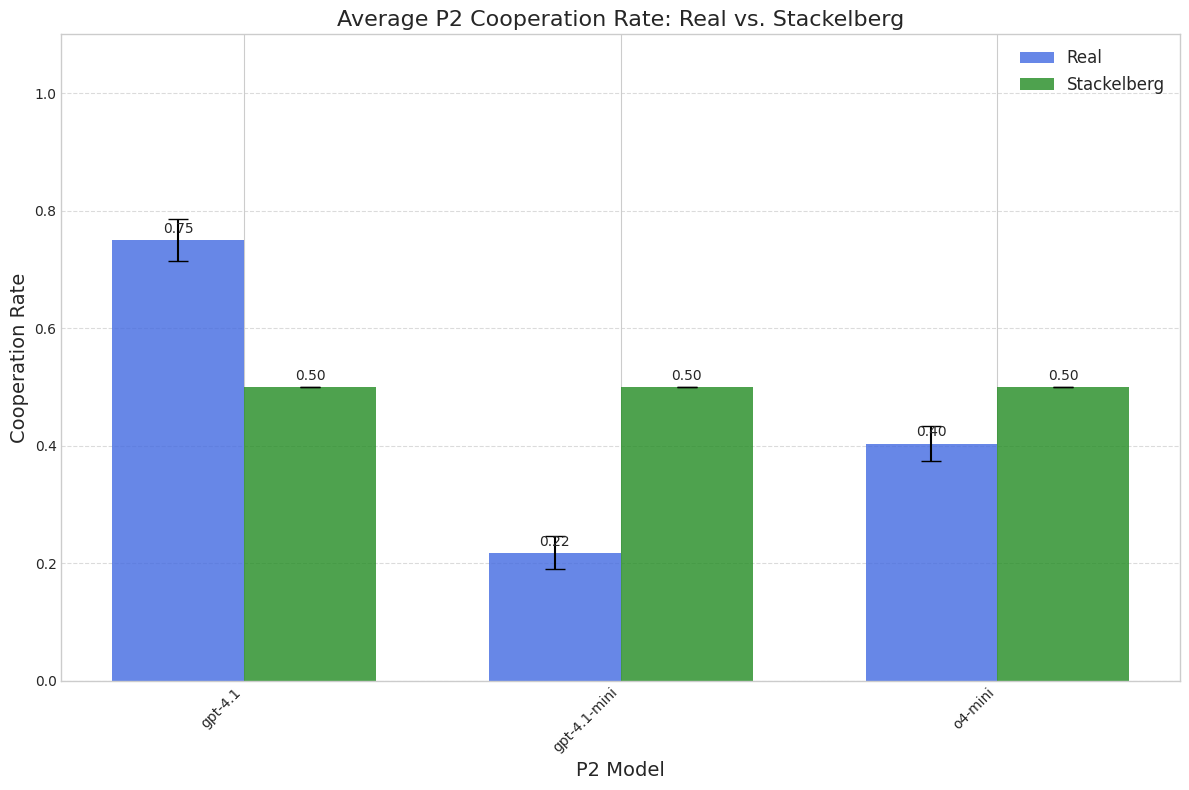

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Assuming df is your DataFrame with the columns specified

# Function to calculate means and confidence intervals for plotting
def get_stats(data, column):
    # Group by model and calculate mean and standard error
    grouped = data.groupby('arg_p2_model')[column].agg(['mean', 'count', 'std'])
    # Calculate 95% confidence interval
    grouped['ci'] = grouped['std'] / np.sqrt(grouped['count']) * 1.96
    return grouped

# PLOT 1: Real vs Simulated Cooperation Rates
def plot_real_vs_simulated(df):
    # Get statistics for real and simulated cooperation
    real_coop = get_stats(df, 'p2_prob_cooperate')
    sim_coop = get_stats(df, 'p2_simulated_prob_cooperate')
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get the unique models
    models = real_coop.index.tolist()
    x = np.arange(len(models))
    width = 0.35
    
    # Create the bars
    real_bars = ax.bar(x - width/2, real_coop['mean'], width, 
                       yerr=real_coop['ci'], label='Real', 
                       color='royalblue', capsize=7, alpha=0.8)
    sim_bars = ax.bar(x + width/2, sim_coop['mean'], width, 
                      yerr=sim_coop['ci'], label='Simulated', 
                      color='darkorange', capsize=7, alpha=0.8)
    
    # Customize the plot
    ax.set_title('Average P2 Cooperation Rate: Real vs. Simulated', fontsize=16)
    ax.set_xlabel('P2 Model', fontsize=14)
    ax.set_ylabel('Cooperation Rate', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(fontsize=12)
    ax.set_ylim(0, 1.1)  # Setting y-limit to accommodate annotations
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add annotations
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10)
    
    add_labels(real_bars)
    add_labels(sim_bars)
    
    plt.tight_layout()
    return fig

# PLOT 2: Real vs Stackelberg Cooperation Rates
def plot_real_vs_stackelberg(df):
    # Get statistics for real and stackelberg cooperation
    real_coop = get_stats(df, 'p2_prob_cooperate')
    # Note: corrected column name to match DataFrame
    stack_coop = get_stats(df, 'stackelberg_p2_prob_cooperate')
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get the unique models
    models = real_coop.index.tolist()
    x = np.arange(len(models))
    width = 0.35
    
    # Create the bars
    real_bars = ax.bar(x - width/2, real_coop['mean'], width, 
                       yerr=real_coop['ci'], label='Real', 
                       color='royalblue', capsize=7, alpha=0.8)
    stack_bars = ax.bar(x + width/2, stack_coop['mean'], width, 
                        yerr=stack_coop['ci'], label='Stackelberg', 
                        color='forestgreen', capsize=7, alpha=0.8)
    
    # Customize the plot
    ax.set_title('Average P2 Cooperation Rate: Real vs. Stackelberg', fontsize=16)
    ax.set_xlabel('P2 Model', fontsize=14)
    ax.set_ylabel('Cooperation Rate', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(fontsize=12)
    ax.set_ylim(0, 1.1)  # Setting y-limit to accommodate annotations
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add annotations
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10)
    
    add_labels(real_bars)
    add_labels(stack_bars)
    
    plt.tight_layout()
    return fig

# Execute both plots
fig1 = plot_real_vs_simulated(df)
plt.savefig('figures/real_vs_simulated_cooperation.png', dpi=300, bbox_inches='tight')

fig2 = plot_real_vs_stackelberg(df)
plt.savefig('figures/real_vs_stackelberg_cooperation.png', dpi=300, bbox_inches='tight')